# Implementing MViTv2-tiny.


In [139]:
# Install Timm
!pip -q install timm

In [140]:
# Imports + Paths

import os, json, re, glob, shutil, subprocess 
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import models, transforms

CODE_DIR    =  "/kaggle/input/....................mvitv2-code/MViTv2 Code"
WORK_DIR    = "/kaggle/working/skin_code"
IMAGES_DIR  = "/kaggle/input/.............../training-dataset/ISIC_2019_Training_Input"
TRAIN_CSV   = "/kaggle/input/.............../training-dataset/data/data/train.csv"
VAL_CSV     = "/kaggle/input/............../training-dataset/data/data/val.csv"

SKINCON_CSV = "/kaggle/input/............../training-dataset/SkinCON_clean.csv"
print("SKINCON_CSV:", SKINCON_CSV)

DATASET_ROOT = "/kaggle/working/skin_data"

SKINCON_CSV: /kaggle/input/datasets/shahed59/training-dataset/SkinCON_clean.csv


In [141]:
# Copy code into /kaggle/working

import os
os.makedirs(WORK_DIR, exist_ok=True)

for fn in ["datasets.py", "train.py"]:
    shutil.copy2(f"{CODE_DIR}/{fn}", f"{WORK_DIR}/{fn}")

In [142]:
# REBUILD SPLIT FOLDERS

if os.path.exists(DATASET_ROOT):
    shutil.rmtree(DATASET_ROOT)
Path(DATASET_ROOT, "train").mkdir(parents=True, exist_ok=True)
Path(DATASET_ROOT, "val").mkdir(parents=True, exist_ok=True)

img_map = {p.name: str(p) for p in Path(IMAGES_DIR).rglob("*") if p.is_file()}

def build_split(csv_path, split):
    df = pd.read_csv(csv_path)
    assert {"filename", "labels"}.issubset(df.columns), f"{csv_path} must have filename, labels"
    linked, missing = 0, 0
    for fn, lab in zip(df["filename"], df["labels"]):
        src = img_map.get(fn)
        if src is None:
            missing += 1
            continue
        dst_dir = Path(DATASET_ROOT, split, str(lab))
        dst_dir.mkdir(parents=True, exist_ok=True)
        dst = dst_dir / fn
        if dst.exists():
            continue
        try:
            os.symlink(src, str(dst))   
        except Exception:
            shutil.copy2(src, str(dst)) 
        linked += 1
    # print(f"{split}: linked={linked}, missing={missing}, rows={len(df)}")

build_split(TRAIN_CSV, "train")
build_split(VAL_CSV, "val")

os.environ["SKINCON_CSV_PATH"] = SKINCON_CSV


In [143]:
# Patched datasets
DATASETS_PY = "/kaggle/working/skin_code/datasets.py"
txt = Path(DATASETS_PY).read_text()
txt = re.sub(
    r"pd\.read_csv\(\s*[\'\"][^\'\"]+\.csv[\'\"]\s*\)",
    r'pd.read_csv(os.environ["SKINCON_CSV_PATH"])',
    txt
)
if re.search(r"^\s*import\s+os\s*$", txt, flags=re.MULTILINE) is None:
    txt = "import os\n" + txt
Path(DATASETS_PY).write_text(txt)
print("Patched datasets.py -> uses SKINCON_CSV_PATH (SkinCON_clean.csv).")

Patched datasets.py -> uses SKINCON_CSV_PATH (SkinCON_clean.csv).


# TRAINING 

In [144]:
TRAIN_PY = "/kaggle/working/skin_code/train.py"
DATASET_ROOT = "/kaggle/working/skin_data"  
BATCH_SIZE = 8
SKINCON_CSV = "/kaggle/input/............./training-dataset/SkinCON_clean.csv"
os.environ["SKINCON_CSV_PATH"] = SKINCON_CSV
print("Using SKINCON_CSV_PATH:", SKINCON_CSV)


def run_train(EPOCHS, OUT_DIR):
    LOG_FILE = f"{OUT_DIR}/train_log.txt"
    os.makedirs(OUT_DIR, exist_ok=True)

    txt = Path(TRAIN_PY).read_text().splitlines()
    new = []
    for line in txt:
        s = line.strip()
        if s.startswith("epoch_num"):
            new.append(f"epoch_num = {EPOCHS}")
        elif s.startswith("batch_size"):
            new.append(f"batch_size = {BATCH_SIZE}")
        elif s.startswith("output_dir"):
            new.append(f"output_dir = r'{OUT_DIR}'")
        elif s.startswith("data_dir"):
            new.append(f"data_dir = r'{DATASET_ROOT}'")
        elif s.startswith("log_file"):
            new.append(f"log_file = r'{LOG_FILE}'")
        else:
            new.append(line)
    Path(TRAIN_PY).write_text("\n".join(new))

    subprocess.run(["python", TRAIN_PY], check=False)

import time
t0 = time.time()

run_train(EPOCHS=30, OUT_DIR="/kaggle/working/out_run30")

t1 = time.time()
print(f"Total training time: {(t1 - t0)/60:.2f} minutes")

from IPython.display import Audio, display
sr = 44100
tone = np.sin(2 * np.pi * 880 * np.linspace(0, 2, sr * 2))
display(Audio(tone, rate=sr, autoplay=True))

Using SKINCON_CSV_PATH: /kaggle/input/datasets/shahed59/training-dataset/SkinCON_clean.csv
root /kaggle/working/skin_data/train
directory /kaggle/working/skin_data/train



Dataset with score



Number of the class = 8
root /kaggle/working/skin_data/val
directory /kaggle/working/skin_data/val



Dataset with score



Number of the class = 8
Epoch 0/0
train Loss: 0.7211 Acc: 0.779479338645935 acc: 0.7555acc: 0.75 acc: 0.75 acc: 0.5 acc: 0.875 acc: 1.0 acc: 0.875 acc: 0.75 acc: 0.75 acc: 0.875 acc: 0.75
val Loss: 0.5020 Acc: 0.8428
Time: 353.74s
Total training time: 6.03 minutes


In [145]:
# Save final_model.pth
import os, re, glob, shutil

OUT_DIR  = "/kaggle/working/out_run30"
LOG_PATH = f"{OUT_DIR}/train_log.txt"

best_epoch = None
best_loss = float("inf")

with open(LOG_PATH, "r") as f:
    for line in f:
        m = re.search(r"epoch:\s*(\d+),\s*loss:\s*([0-9.eE+-]+)", line)
        if not m:
            continue
        epoch = int(m.group(1))
        loss  = float(m.group(2))
        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch

if best_epoch is None:
    raise RuntimeError("Could not find validation loss in train_log.txt")

best_ckpt = f"{OUT_DIR}/mvitv2t_{best_epoch}.pth"
final_path = f"{OUT_DIR}/final_model.pth"
shutil.copy2(best_ckpt, final_path)

'/kaggle/working/out_run30/final_model.pth'

# METRICS (creates measure_export.py)

In [146]:
%%writefile /kaggle/working/measure_export.py
import torch
import timm
from torch.utils.data import DataLoader
from torchvision import models, transforms
import os, json, re, glob, shutil, subprocess 
import pandas as pd
import numpy as np

import torch.nn as nn

DATASET_ROOT = "/kaggle/working/skin_data"

CKPT_PATH = "/kaggle/working/out_run30/final_model.pth"
OUT_DIR = "/kaggle/working/out_run30/metrics"

NUM_CLASSES  = 8
BATCH_SIZE   = 32
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

os.environ["SKINCON_CSV_PATH"] = "/kaggle/input/................../training-dataset/SkinCON_clean.csv"
print("Using SKINCON_CSV_PATH:", os.environ["SKINCON_CSV_PATH"])

import sys
sys.path.insert(0, "/kaggle/working/skin_code")
from datasets import build_dataset

os.makedirs(OUT_DIR, exist_ok=True)

tfm = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

ds_val, _ = build_dataset(is_train=False, nb_classes=NUM_CLASSES, dataset_root=DATASET_ROOT, transform=tfm)


paths = None
if hasattr(ds_val, "samples") and ds_val.samples is not None and len(ds_val.samples) > 0:
    paths = [item[0] for item in ds_val.samples]
elif hasattr(ds_val, "imgs") and ds_val.imgs is not None and len(ds_val.imgs) > 0:
    paths = [item[0] for item in ds_val.imgs]
elif hasattr(ds_val, "image_paths") and ds_val.image_paths is not None and len(ds_val.image_paths) > 0:
    paths = list(ds_val.image_paths)
if paths is None:
    print("WARNING: could not extract image paths from ds_val; val_image_ids.npy not saved.")
else:
    image_ids = [os.path.splitext(os.path.basename(p))[0] for p in paths]
    np.save(os.path.join(OUT_DIR, "val_image_ids.npy"), np.array(image_ids))

dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#----------Model Building--------
# model = timm.create_model("mvitv2_tiny", pretrained=False, num_classes=0)
# num_ftrs = model.num_features
# model.head = SelfMLPHead(in_features=num_ftrs, num_classes=NUM_CLASSES, hidden=512, dropout=0.2)
#-----------------------------
model = timm.create_model("mvitv2_tiny", pretrained=False, num_classes=NUM_CLASSES)
#----------------------------------
state = torch.load(CKPT_PATH, map_location="cpu")
model.load_state_dict(state, strict=True)
model.to(DEVICE).eval()

all_probs = []
all_yhard = []
all_ysoft = []

correct1 = 0
total = 0

def topk_acc(logits, y, k=5):
    _, pred = logits.topk(k, 1, True, True)
    return pred.eq(y.view(-1,1)).any(dim=1).float()

top5_hits = []

with torch.no_grad():
    for x, y_hard, y_soft in dl_val:
        x = x.to(DEVICE, non_blocking=True)
        y_hard = y_hard.to(DEVICE, non_blocking=True)

        logits = model(x)
        probs = torch.softmax(logits, dim=1)

        pred1 = probs.argmax(dim=1)
        correct1 += (pred1 == y_hard).sum().item()
        total += y_hard.size(0)

        top5_hits.append(topk_acc(logits, y_hard, k=5).cpu().numpy())

        all_probs.append(probs.cpu().numpy())
        all_yhard.append(y_hard.cpu().numpy())
        all_ysoft.append(y_soft.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_yhard = np.concatenate(all_yhard, axis=0)
all_ysoft = np.concatenate(all_ysoft, axis=0)
top5_hits = np.concatenate(top5_hits, axis=0)

acc1 = correct1 / total
acc5 = float(top5_hits.mean())

np.save(os.path.join(OUT_DIR, "val_probs.npy"), all_probs)
np.save(os.path.join(OUT_DIR, "val_yhard.npy"), all_yhard)
np.save(os.path.join(OUT_DIR, "val_ysoft.npy"), all_ysoft)

summary = {
    "checkpoint": CKPT_PATH,
    "dataset_root": DATASET_ROOT,
    "skincon_csv": os.environ["SKINCON_CSV_PATH"],
    "n_val": int(total),
    "acc_top1": float(acc1),
    "acc_top5": float(acc5),
}
with open(os.path.join(OUT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

y_pred = all_probs.argmax(axis=1)
p_pred = all_probs.max(axis=1)
csv_path = os.path.join(OUT_DIR, "val_pred_table.csv")
with open(csv_path, "w") as f:
    f.write("idx,y_true,y_pred,prob_pred\n")
    for i,(yt, yp, pp) in enumerate(zip(all_yhard, y_pred, p_pred)):
        f.write(f"{i},{int(yt)},{int(yp)},{float(pp)}\n")

print("Saved:")
print(" -", os.path.join(OUT_DIR, "summary.json"))
print(" -", os.path.join(OUT_DIR, "val_pred_table.csv"))
print(" -", os.path.join(OUT_DIR, "val_probs.npy"))
print(" -", os.path.join(OUT_DIR, "val_yhard.npy"))
print(" -", os.path.join(OUT_DIR, "val_ysoft.npy"))
print(" -", os.path.join(OUT_DIR, "val_image_ids.npy"))

Overwriting /kaggle/working/measure_export.py


# Loading trained model checkpoint, runs evaluation on the validation set, computes all metrics (accuracy, coverage, avg set size, hit-rate, τ, etc.), and exports them to files (JSON/CSV/NPY) in out_sanity/

In [166]:
!python /kaggle/working/measure_export.py


Using SKINCON_CSV_PATH: /kaggle/input/datasets/shahed59/training-dataset/SkinCON_clean.csv
root /kaggle/working/skin_data/val
directory /kaggle/working/skin_data/val



Dataset with score



Number of the class = 8
Saved:
 - /kaggle/working/out_run30/metrics/summary.json
 - /kaggle/working/out_run30/metrics/val_pred_table.csv
 - /kaggle/working/out_run30/metrics/val_probs.npy
 - /kaggle/working/out_run30/metrics/val_yhard.npy
 - /kaggle/working/out_run30/metrics/val_ysoft.npy
 - /kaggle/working/out_run30/metrics/val_image_ids.npy


In [167]:
# Final checklist
CKPT_PATH = "/kaggle/working/out_run30/final_model.pth"
DATASET_ROOT = "/kaggle/working/skin_data"
SKINCON_CSV = "/kaggle/input/training-dataset/SkinCON_clean.csv"  
OUT_DIR   = "/kaggle/working/out_run30/metrics"

print("1) checkpoint exists:", os.path.exists(CKPT_PATH))
print("2) train folder exists:", os.path.exists(DATASET_ROOT + "/train"))
print("3) val folder exists:", os.path.exists(DATASET_ROOT + "/val"))
print("4) metrics dir exists:", os.path.exists(OUT_DIR))
print("5) SkinCON CSV exists:", os.path.exists(SKINCON_CSV))

1) checkpoint exists: True
2) train folder exists: True
3) val folder exists: True
4) metrics dir exists: True
5) SkinCON CSV exists: False


# Baseline  Metrics 

In [168]:
# Baseline Classification Top-1 / Top-5 Accuracy
# ==============================================
PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"

probs = np.load(PROBS_NPY)
y_true = np.load(YHARD_NPY).astype(int)

# Top-1
top1_pred = probs.argmax(axis=1)
top1_acc = (top1_pred == y_true).mean()

# Top-5
top5_pred = np.argsort(-probs, axis=1)[:, :5]
top5_acc = np.mean([y_true[i] in top5_pred[i] for i in range(len(y_true))])

print("Baseline Accuracy")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

Baseline Accuracy
Top-1 Accuracy: 0.8428
Top-5 Accuracy: 0.9981


In [169]:
# Baseline Conformal (val-calibration) from saved .npy
# ====================================================
import os
def normalize_key(s):
    """
    Normalize image identifiers for matching:
    - remove directory paths
    - remove .jpg extension
    - KEEP '_downsampled' intact
    """
    s = str(s).strip()
    s = os.path.basename(s)
    if s.lower().endswith(".jpg"):
        s = s[:-4]
    return s

PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"

ALPHA = 0.1  # 0.1 -> target 90% coverage
probs = np.load(PROBS_NPY)              
y_true = np.load(YHARD_NPY).astype(int) 
N, K = probs.shape

y_pred = probs.argmax(axis=1)

per_class_recalls = []
for c in range(K):
    mask = (y_true == c)
    if mask.sum() == 0:
        continue
    per_class_recalls.append((y_pred[mask] == c).mean())
balance_acc = float(np.mean(per_class_recalls)) if len(per_class_recalls) > 0 else float("nan")

onehot = np.zeros_like(probs)
onehot[np.arange(N), y_true] = 1.0
brier = float(np.mean(np.sum((probs - onehot) ** 2, axis=1)))

def ece_score(probs, y_true, n_bins=15):
    conf = probs.max(axis=1)
    pred = probs.argmax(axis=1)
    acc = (pred == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        m = (conf > lo) & (conf <= hi)
        if m.sum() == 0:
            continue
        ece += (m.mean()) * abs(acc[m].mean() - conf[m].mean())
    return float(ece)

ece = ece_score(probs, y_true, n_bins=15)

p_true = probs[np.arange(N), y_true]
scores = 1.0 - p_true

q_level = np.ceil((N + 1) * (1 - ALPHA)) / N
tau = float(np.quantile(scores, q_level, method="higher"))

threshold = 1.0 - tau
pred_sets = probs >= threshold          

empty = pred_sets.sum(axis=1) == 0
if empty.any():
    top1 = probs.argmax(axis=1)
    pred_sets[empty, top1[empty]] = True

set_sizes = pred_sets.sum(axis=1)
hits = pred_sets[np.arange(N), y_true]

baseline_coverage = float(hits.mean())
baseline_avg_set_size = float(set_sizes.mean())

import pandas as pd
SKINCON_CSV = "/kaggle/input/........../training-dataset/SkinCON_clean.csv"
VAL_IDS_NPY = "/kaggle/working/out_run30/metrics/val_image_ids.npy"
val_img_ids = np.load(VAL_IDS_NPY, allow_pickle=True).astype(str)
skincon_df = pd.read_csv(SKINCON_CSV)

SKINCON_COUNT_COLS_IN_CLASS_ORDER = [
    "actinic_keratosis",
    "basal_cell_carcinoma",
    "benign_keratosis",
    "dermatofibroma",
    "melanoma",
    "nevus",
    "squamous_cell_carcinoma",
    "vascular_lesion",
]
skincon_counts_map = {}
for _, row in skincon_df.iterrows():
    img_key = normalize_key(row["file"])
    counts = np.array([row[c] for c in SKINCON_COUNT_COLS_IN_CLASS_ORDER], dtype=np.float32)
    counts = np.nan_to_num(counts, nan=0.0)
    skincon_counts_map[img_key] = counts

hit_rates = []
unmatched = 0

for i, img_key in enumerate(val_img_ids):
    model_set = set(np.where(pred_sets[i])[0].tolist())
    k = len(model_set)
    if k == 0:
        hit_rates.append(0.0)
        continue

    key = normalize_key(img_key)
    counts = skincon_counts_map.get(key, None)
    if counts is None:
        unmatched += 1
        hit_rates.append(0.0)
        continue

    topk_human = set(np.argsort(-counts)[:k].tolist())
    hit = len(model_set.intersection(topk_human)) / k
    hit_rates.append(hit)
baseline_hit_rate = float(np.mean(hit_rates))


# RAPS — Metrics

In [170]:
# RAPS — Classification metrics (Top-1 / Top-5)
# =======================================
PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"

probs = np.load(PROBS_NPY)              
y_true = np.load(YHARD_NPY).astype(int) 

# Top-1
top1_pred = probs.argmax(axis=1)
top1_acc = float((top1_pred == y_true).mean())
# Top-5
top5_pred = np.argsort(-probs, axis=1)[:, :5]
top5_acc = float(np.mean([y_true[i] in top5_pred[i] for i in range(len(y_true))]))


In [171]:
# RAPS — Conformal metrics (val-calibration)
# ==============================================
import os
def normalize_key(s):
    """
    Normalize image identifiers for matching:
    - remove directory paths
    - remove .jpg extension
    - KEEP '_downsampled' intact
    """
    s = str(s).strip()
    s = os.path.basename(s)
    if s.lower().endswith(".jpg"):
        s = s[:-4]
    return s

PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"

ALPHA = 0.1      # target 90% coverage
LAMBDA = 0.01    # size penalty (raps lambda)
K_REG = 5        # regularization cutoff

probs = np.load(PROBS_NPY)
y_true = np.load(YHARD_NPY).astype(int)
N, K = probs.shape

def raps_score(p_row, y, lam=LAMBDA, k_reg=K_REG):
    """
    RAPS nonconformity score for true label y.
    Implements: cumulative mass up to true label rank + lambda*max(rank-k_reg, 0)
    """
    order = np.argsort(-p_row)  
    ranks = np.empty(K, dtype=int)
    ranks[order] = np.arange(1, K + 1)  # 1..K

    r = ranks[y] 
    cum = p_row[order[:r]].sum()
    return 1.0 - cum + lam * max(r - k_reg, 0)

scores = np.array([raps_score(probs[i], y_true[i]) for i in range(N)], dtype=float)

q_level = np.ceil((N + 1) * (1 - ALPHA)) / N
tau = float(np.quantile(scores, q_level, method="higher"))

def raps_pred_set(p_row, tau, lam=LAMBDA, k_reg=K_REG):
    """
    Build RAPS prediction set Γ(x) = smallest set such that
    (1 - cum_mass) + lambda*max(m-k_reg,0) <= tau
    where m is set size (top-m).
    """
    order = np.argsort(-p_row)
    cum = 0.0
    S = []
    m = 0
    for idx in order:
        m += 1
        cum += float(p_row[idx])
        score_m = 1.0 - cum + lam * max(m - k_reg, 0)
        S.append(idx)
        if score_m <= tau:
            break
    return np.array(S, dtype=int)

hits = np.zeros(N, dtype=bool)
set_sizes = np.zeros(N, dtype=int)

for i in range(N):
    S = raps_pred_set(probs[i], tau)
    set_sizes[i] = len(S)
    hits[i] = (y_true[i] in S)
# ---------------------------------------------------
sets_raps = np.zeros((N, K), dtype=bool)
for i in range(N):
    S = raps_pred_set(probs[i], tau)
    sets_raps[i, S] = True
# ---------------------------------------------------
raps_coverage = float(hits.mean())
raps_avg_set_size = float(set_sizes.mean())
tau_raps  = tau  

import pandas as pd
SKINCON_CSV = "/kaggle/input/................../training-dataset/SkinCON_clean.csv"
VAL_IDS_NPY = "/kaggle/working/out_run30/metrics/val_image_ids.npy"

val_img_ids = np.load(VAL_IDS_NPY, allow_pickle=True).astype(str)
skincon_df = pd.read_csv(SKINCON_CSV)

SKINCON_COUNT_COLS_IN_CLASS_ORDER = [
    "actinic_keratosis",
    "basal_cell_carcinoma",
    "benign_keratosis",
    "dermatofibroma",
    "melanoma",
    "nevus",
    "squamous_cell_carcinoma",
    "vascular_lesion",
]

skincon_counts_map = {}
for _, row in skincon_df.iterrows():
    img_key = normalize_key(row["file"])
    counts = np.array([row[c] for c in SKINCON_COUNT_COLS_IN_CLASS_ORDER], dtype=np.float32)
    counts = np.nan_to_num(counts, nan=0.0, posinf=0.0, neginf=0.0)
    skincon_counts_map[img_key] = counts

hit_rates = []
unmatched = 0

for i, img_key in enumerate(val_img_ids):
    model_set = set(np.where(sets_raps[i])[0].tolist())
    k = len(model_set)
    if k == 0:
        hit_rates.append(0.0)
        continue

    #counts = skincon_counts_map.get(img_key, None)
    key = normalize_key(img_key)
    counts = skincon_counts_map.get(key, None)

    if counts is None:
        unmatched += 1
        hit_rates.append(0.0)
        continue

    topk_human = set(np.argsort(-counts)[:k].tolist())
    hit = len(model_set.intersection(topk_human)) / k
    hit_rates.append(hit)

raps_hit_rate = float(np.mean(hit_rates))
raps_referral_rate  = float((set_sizes > 1).mean())
raps_singleton_rate = float((set_sizes == 1).mean())

# DRAPS — Metrics

In [172]:
# DRAPS — Classification metrics (Top-1 / Top-5)
# =============================================
PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"

probs  = np.load(PROBS_NPY)              
y_true = np.load(YHARD_NPY).astype(int)  

top1_pred = probs.argmax(axis=1)
top1_acc  = float((top1_pred == y_true).mean())

top5_pred = np.argsort(-probs, axis=1)[:, :5]
top5_acc  = float(np.mean([y_true[i] in top5_pred[i] for i in range(len(y_true))]))

In [173]:
# DRAPS — Conformal metrics (soft-label calibrated)
# ========================================================
import os
def normalize_key(s):
    """
    Normalize image identifiers for matching:
    - remove directory paths
    - remove .jpg extension
    - KEEP '_downsampled' intact
    """
    s = str(s).strip()
    s = os.path.basename(s)
    if s.lower().endswith(".jpg"):
        s = s[:-4]
    return s

PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"
YSOFT_NPY = "/kaggle/working/out_run30/metrics/val_ysoft.npy"

ALPHA  = 0.1
LAMBDA = 0.01
K_REG  = 5

probs  = np.load(PROBS_NPY)               
y_true = np.load(YHARD_NPY).astype(int)   
y_soft = np.load(YSOFT_NPY).astype(float) 
N, K = probs.shape

def draps_score_given_label(p_row, y, lam=LAMBDA, k_reg=K_REG):
    order = np.argsort(-p_row)
    ranks = np.empty(K, dtype=int)
    ranks[order] = np.arange(1, K + 1)  
    r = ranks[y]
    cum = p_row[order[:r]].sum()
    return 1.0 - cum + lam * max(r - k_reg, 0)

scores = np.zeros(N, dtype=float)
for i in range(N):
    s = 0.0
    for y in range(K):
        w = float(y_soft[i, y])
        if w > 0:
            s += w * draps_score_given_label(probs[i], y)
    scores[i] = s

q_level = np.ceil((N + 1) * (1 - ALPHA)) / N
tau = float(np.quantile(scores, q_level, method="higher"))

def draps_pred_set(p_row, tau, lam=LAMBDA, k_reg=K_REG):
    order = np.argsort(-p_row)
    cum = 0.0
    S = []
    m = 0
    for idx in order:
        m += 1
        cum += float(p_row[idx])
        score_m = 1.0 - cum + lam * max(m - k_reg, 0)
        S.append(idx)
        if score_m <= tau:
            break
    return np.array(S, dtype=int)

hits = np.zeros(N, dtype=bool)
set_sizes = np.zeros(N, dtype=int)
soft_hits = np.zeros(N, dtype=float)  

for i in range(N):
    S = draps_pred_set(probs[i], tau)
    set_sizes[i] = len(S)
    hits[i] = (y_true[i] in S)
    soft_hits[i] = float(y_soft[i, S].sum())

#-----------------------------------------------------
sets_draps = np.zeros((N, K), dtype=bool)
for i in range(N):
    S = draps_pred_set(probs[i], tau)
    sets_draps[i, S] = True
#-----------------------------------------------------

draps_coverage      = float(hits.mean())    
draps_avg_set_size  = float(set_sizes.mean())
draps_hit_rate      = draps_coverage
draps_soft_hit_rate = float(soft_hits.mean()) 
tau_draps = tau   

import pandas as pd
SKINCON_CSV = "/kaggle/input/.............../training-dataset/SkinCON_clean.csv"
VAL_IDS_NPY = "/kaggle/working/out_run30/metrics/val_image_ids.npy"

val_img_ids = np.load(VAL_IDS_NPY, allow_pickle=True).astype(str)
skincon_df = pd.read_csv(SKINCON_CSV)

SKINCON_COUNT_COLS_IN_CLASS_ORDER = [
    "actinic_keratosis",
    "basal_cell_carcinoma",
    "benign_keratosis",
    "dermatofibroma",
    "melanoma",
    "nevus",
    "squamous_cell_carcinoma",
    "vascular_lesion",
]
skincon_counts_map = {}
for _, row in skincon_df.iterrows():
    # img_key = str(row["file"])  
    img_key = normalize_key(row["file"])  
    counts = np.array([row[c] for c in SKINCON_COUNT_COLS_IN_CLASS_ORDER], dtype=np.float32)
    counts = np.nan_to_num(counts, nan=0.0, posinf=0.0, neginf=0.0)
    skincon_counts_map[img_key] = counts

hit_rates = []
unmatched = 0

for i, img_key in enumerate(val_img_ids):
    model_set = set(np.where(sets_draps[i])[0].tolist())
    k = len(model_set)
    if k == 0:
        hit_rates.append(0.0)
        continue

    #counts = skincon_counts_map.get(img_key, None)
    key = normalize_key(img_key)
    counts = skincon_counts_map.get(key, None)

    if counts is None:
        unmatched += 1
        hit_rates.append(0.0)
        continue

    topk_human = set(np.argsort(-counts)[:k].tolist())
    hit = len(model_set.intersection(topk_human)) / k
    hit_rates.append(hit)

draps_hit_rate = float(np.mean(hit_rates))
draps_referral_rate  = float((set_sizes > 1).mean())
draps_singleton_rate = float((set_sizes == 1).mean())

# Coverage-Size Curve and Risk-Coverage Curver 

In [174]:
# Coverage-Size Curve (RAPS vs DRAPS) and Risk-Coverage Curver (DRAPS)
import numpy as np
import matplotlib.pyplot as plt
import os

FIG_DIR = "/kaggle/working/out_run30/metrics/figures"
os.makedirs(FIG_DIR, exist_ok=True)

PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YHARD_NPY = "/kaggle/working/out_run30/metrics/val_yhard.npy"
YSOFT_NPY = "/kaggle/working/out_run30/metrics/val_ysoft.npy"   # DRAPS only

probs  = np.load(PROBS_NPY)                 
y_true = np.load(YHARD_NPY).astype(int)     
y_soft = np.load(YSOFT_NPY).astype(float)   

N, K = probs.shape

def baseline_pred_sets(probs, tau):
    thr = 1.0 - float(tau)
    sets = (probs >= thr)                   
    empty = sets.sum(axis=1) == 0
    if empty.any():
        top1 = probs.argmax(axis=1)
        sets[empty, top1[empty]] = True
    return sets

def raps_pred_set_single(p_row, tau, lam=0.01, k_reg=5):
    order = np.argsort(-p_row)
    cum = 0.0
    S = []
    m = 0
    for idx in order:
        m += 1
        cum += float(p_row[idx])
        score_m = 1.0 - cum + lam * max(m - k_reg, 0)
        S.append(idx)
        if score_m <= tau:
            break
    out = np.zeros_like(p_row, dtype=bool)
    out[np.array(S, dtype=int)] = True
    return out

def raps_pred_sets(probs, tau, lam=0.01, k_reg=5):
    sets = np.zeros_like(probs, dtype=bool)
    for i in range(probs.shape[0]):
        sets[i] = raps_pred_set_single(probs[i], tau, lam=lam, k_reg=k_reg)
    return sets

def raps_score_given_label(p_row, y, lam=0.01, k_reg=5):
    order = np.argsort(-p_row)
    ranks = np.empty(K, dtype=int)
    ranks[order] = np.arange(1, K + 1)      # 1..K
    r = ranks[y]
    cum = p_row[order[:r]].sum()
    return 1.0 - float(cum) + lam * max(r - k_reg, 0)

def draps_scores(probs, y_soft, lam=0.01, k_reg=5):
    scores = np.zeros(N, dtype=float)
    for i in range(N):
        s = 0.0
        for y in range(K):
            w = float(y_soft[i, y])
            if w > 0:
                s += w * raps_score_given_label(probs[i], y, lam=lam, k_reg=k_reg)
        scores[i] = s
    return scores

def curve_stats_from_sets(sets, probs, y_true):
    sizes = sets.sum(axis=1).astype(int)
    hits = sets[np.arange(len(y_true)), y_true].astype(float)

    coverage_conformal = float(hits.mean())
    avg_set_size = float(sizes.mean())

    singleton = (sizes == 1)
    selective_coverage = float(singleton.mean())

    if singleton.any():
        pred_single = np.argmax(sets[singleton].astype(int), axis=1)
        acc_single = float((pred_single == y_true[singleton]).mean())
        selective_risk = 1.0 - acc_single
    else:
        selective_risk = np.nan

    referral_rate = 1.0 - selective_coverage
    return {
        "coverage_conformal": coverage_conformal,
        "avg_set_size": avg_set_size,
        "selective_coverage": selective_coverage,
        "selective_risk": selective_risk,
        "referral_rate": referral_rate,
    }

LAMBDA = 0.01
K_REG = 5
n_pts = 41

tau_grid_baseline = np.linspace(0.0, 1.0, n_pts)

tau_max_raps = 1.0 + LAMBDA * max(K - K_REG, 0)
tau_grid_raps = np.linspace(0.0, tau_max_raps, n_pts)

curves = {}

xs, ys, rc_x, rc_y = [], [], [], []
for tau in tau_grid_baseline:
    sets = baseline_pred_sets(probs, tau)
    st = curve_stats_from_sets(sets, probs, y_true)
    ys.append(st["coverage_conformal"])
    xs.append(st["avg_set_size"])
    rc_x.append(st["selective_coverage"])
    rc_y.append(st["selective_risk"])
curves["Baseline"] = {"cov": np.array(ys), "size": np.array(xs),
                      "rc_cov": np.array(rc_x), "rc_risk": np.array(rc_y)}

xs, ys, rc_x, rc_y = [], [], [], []
for tau in tau_grid_raps:
    sets = raps_pred_sets(probs, tau, lam=LAMBDA, k_reg=K_REG)
    st = curve_stats_from_sets(sets, probs, y_true)
    ys.append(st["coverage_conformal"])
    xs.append(st["avg_set_size"])
    rc_x.append(st["selective_coverage"])
    rc_y.append(st["selective_risk"])
curves["RAPS"] = {"cov": np.array(ys), "size": np.array(xs),
                  "rc_cov": np.array(rc_x), "rc_risk": np.array(rc_y)}

tau_center_draps = tau_draps 
tau_grid_draps = np.linspace(0.0, tau_center_draps * 2.0, n_pts)

xs, ys, rc_x, rc_y = [], [], [], []
for tau in tau_grid_draps:
    sets = raps_pred_sets(probs, tau, lam=LAMBDA, k_reg=K_REG) 
    st = curve_stats_from_sets(sets, probs, y_true)
    ys.append(st["coverage_conformal"])
    xs.append(st["avg_set_size"])
    rc_x.append(st["selective_coverage"])
    rc_y.append(st["selective_risk"])

curves["DRAPS"] = {"cov": np.array(ys), "size": np.array(xs),
                   "rc_cov": np.array(rc_x), "rc_risk": np.array(rc_y)}

print("curves keys:", curves.keys())
for k in ["RAPS", "DRAPS"]:
    if k in curves:
        print(k, "len(size)=", len(curves[k]["size"]), "len(cov)=", len(curves[k]["cov"]),
              "first=", (curves[k]["size"][0] if len(curves[k]["size"]) else None))

keep = {"Baseline", "RAPS", "DRAPS"}
curves = {k: v for k, v in curves.items() if k in keep}

COLOR_MAP = { "Baseline": "#17becf", "RAPS":"#ff7f0e","DRAPS":"#2ca02c",}

# Plot 1: Coverage–Size trade-off (conformal coverage vs avg set size)
plt.figure()
for name, d in curves.items():
    plt.plot(
        d["size"], d["cov"],
        marker="o", linewidth=1.8, markersize=4,
        color=COLOR_MAP[name], label=name
    )
plt.xlabel("Average Set Size", fontsize=11)
plt.ylabel("Coverage", fontsize=11)
plt.title("Coverage–Size Trade-off", fontsize=14)
plt.xlim(0.9, 3.0)       
plt.ylim(0.85, 1.005)    
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("coverage_size_MViTv2.pdf", bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "coverage_size_MViTv2.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print("Saving to:", os.path.join(FIG_DIR, "coverage_size_MViTv2.png"))

# Plot 2: Risk–Coverage (selective) curve
plt.figure()
for name, d in curves.items():
    plt.plot(
        d["rc_cov"], d["rc_risk"],
        marker="o", linewidth=1.8, markersize=4,
        color=COLOR_MAP[name], label=name
    )
plt.xlabel("Selective Coverage (decisions made)", fontsize=11)
plt.ylabel("Selective Risk (error on decided cases)", fontsize=11)
plt.title("Risk–Coverage Curve", fontsize=14)
plt.xlim(0.5, 1.0)    
plt.ylim(0.0, 0.12)   
#plt.ylim(1e-3, 0.2)
#plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig("risk_coverage_MViTv2.pdf", bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "risk_coverage_MViTv2.png"),
            dpi=300, bbox_inches="tight")
plt.show()
plt.close()
print(os.listdir(FIG_DIR))

curves keys: dict_keys(['Baseline', 'RAPS', 'DRAPS'])
RAPS len(size)= 41 len(cov)= 41 first= 8.0
DRAPS len(size)= 41 len(cov)= 41 first= 8.0


Saving to: /kaggle/working/out_run30/metrics/figures/coverage_size_MViTv2.png


['subgroup_coverage_SEX_raps_vs_draps_MViTv2.pdf', 'reliability_MViTv2.png', 'risk_coverage_MViTv2.png', 'subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.pdf', 'subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.png', 'subgroup_coverage_AGE_raps_vs_draps_MViTv2.png', 'subgroup_coverage_SEX_raps_vs_draps_MViTv2.png', 'coverage_size_MViTv2.png', 'reliability_MViTv2.pdf', 'subgroup_coverage_AGE_raps_vs_draps_MViTv2.pdf']


# Soft-label KL Divergence (DRAPS)

In [175]:
import numpy as np
PROBS_NPY = "/kaggle/working/out_run30/metrics/val_probs.npy"
YSOFT_NPY = "/kaggle/working/out_run30/metrics/val_ysoft.npy"

probs  = np.load(PROBS_NPY).astype(float)   
y_soft = np.load(YSOFT_NPY).astype(float)   

eps = 1e-12
probs  = np.clip(probs, eps, 1.0)
probs  = probs / probs.sum(axis=1, keepdims=True)

y_soft = np.clip(y_soft, eps, 1.0)
y_soft = y_soft / y_soft.sum(axis=1, keepdims=True)

kl_per = np.sum(y_soft * (np.log(y_soft) - np.log(probs)), axis=1)

kl_mean = float(np.mean(kl_per))
kl_median = float(np.median(kl_per))
kl_p90 = float(np.percentile(kl_per, 90))
kl_std = float(np.std(kl_per))

# Subgroup Coverage and Gap Δ for RAPS vs DRAPS

# Sex Sub-group

  method subgroup    n  coverage
2   RAPS      nan   20  0.950000
0   RAPS   female  741  0.910931
1   RAPS     male  810  0.898765

RAPS coverage gap Δ: 0.0512


  method subgroup    n  coverage
2  DRAPS      nan   20  0.950000
0  DRAPS   female  741  0.948718
1  DRAPS     male  810  0.944444

DRAPS coverage gap Δ: 0.0056


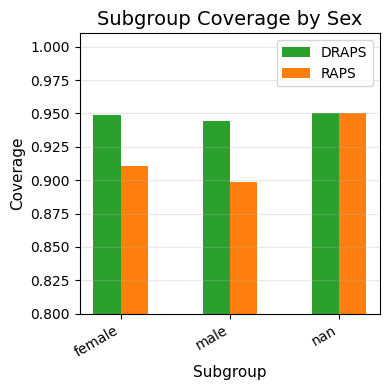

Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_SEX_raps_vs_draps_MViTv2.png
Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_SEX_raps_vs_draps_MViTv2.pdf


In [176]:
import numpy as np
import pandas as pd

OUT_DIR = "/kaggle/working/out_run30/metrics"
META_CSV = "/kaggle/input/.............../training-dataset/ISIC_2019_Training_Metadata.csv"
SUBGROUP_COL = "sex"   

image_ids = np.load(f"{OUT_DIR}/val_image_ids.npy")
y_true    = np.load(f"{OUT_DIR}/val_yhard.npy").astype(int)

def subgroup_coverage(sets_bool, name):
    meta = pd.read_csv(META_CSV).set_index("image")
    meta = meta.loc[image_ids].reset_index()
    sub = meta[SUBGROUP_COL].astype(str).values
    rows = []
    for g in np.unique(sub):
        idx = (sub == g)
        if idx.sum() == 0:
            continue
        cov = float(sets_bool[idx, y_true[idx]].mean())
        rows.append({"method": name, "subgroup": g, "n": int(idx.sum()), "coverage": cov})

    df = pd.DataFrame(rows).sort_values("coverage", ascending=False)
    delta = float(df["coverage"].max() - df["coverage"].min())
    return df, delta


df_raps, delta_raps = subgroup_coverage(sets_raps, "RAPS")
print(df_raps)
print(f"\nRAPS coverage gap Δ: {delta_raps:.4f}")

df_draps, delta_draps = subgroup_coverage(sets_draps, "DRAPS")
print("\n" + "="*60 + "\n")
print(df_draps)
print(f"\nDRAPS coverage gap Δ: {delta_draps:.4f}")

plot_df = pd.concat([df_raps, df_draps], ignore_index=True)
pv = plot_df.pivot_table(
    index="subgroup",
    columns="method",
    values="coverage",
    aggfunc="mean"
)
x = np.arange(len(pv.index))
w = 0.25  # bar width

fig, ax = plt.subplots(figsize=(4, 4))

ax.bar(x - w/2, pv["DRAPS"], width=w, label="DRAPS", color="#2ca02c")
ax.bar(x + w/2, pv["RAPS"],  width=w, label="RAPS",  color="#ff7f0e")

ax.set_xticks(x)
ax.set_xticklabels(pv.index, rotation=30, ha="right")
ax.set_ylabel("Coverage", fontsize=11)
ax.set_xlabel("Subgroup", fontsize=11)
ax.set_title("Subgroup Coverage by Sex", fontsize=14)
ax.set_ylim(0.8, 1.01)
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()

png_path = os.path.join(FIG_DIR, "subgroup_coverage_SEX_raps_vs_draps_MViTv2.png")
pdf_path = os.path.join(FIG_DIR, "subgroup_coverage_SEX_raps_vs_draps_MViTv2.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")

plt.show()
plt.close()

print("Saved:", png_path)
print("Saved:", pdf_path)

# Age Sub-group

In [177]:
import numpy as np
import pandas as pd

OUT_DIR = "/kaggle/working/out_run30/metrics"
META_CSV = "/kaggle/input/.............../training-dataset/ISIC_2019_Training_Metadata.csv"
SUBGROUP_COL = "age_approx"   

image_ids = np.load(f"{OUT_DIR}/val_image_ids.npy")
y_true    = np.load(f"{OUT_DIR}/val_yhard.npy").astype(int)

def subgroup_coverage(sets_bool, name):
    meta = pd.read_csv(META_CSV).set_index("image")
    meta = meta.loc[image_ids].reset_index()
    if SUBGROUP_COL == "age_approx":
        age = pd.to_numeric(meta["age_approx"], errors="coerce")
        bins   = [0, 20, 40, 60, 80, 120]
        labels = ["0–19", "20–39", "40–59", "60–79", "80+"]
    
        sub = pd.cut(age, bins=bins, labels=labels, right=False, include_lowest=True)
        sub = sub.astype(str).values   
    else:
        sub = meta[SUBGROUP_COL].astype(str).values
    
    rows = []
    for g in np.unique(sub):
        idx = (sub == g)
        if idx.sum() == 0:
            continue
        cov = float(sets_bool[idx, y_true[idx]].mean())
        rows.append({"method": name, "subgroup": g, "n": int(idx.sum()), "coverage": cov})

    df = pd.DataFrame(rows).sort_values("coverage", ascending=False)
    delta = float(df["coverage"].max() - df["coverage"].min())
    return df, delta

df_raps, delta_raps = subgroup_coverage(sets_raps, "RAPS")
print(df_raps)
print(f"\nRAPS coverage gap Δ: {delta_raps:.4f}")

df_draps, delta_draps = subgroup_coverage(sets_draps, "DRAPS")
print("\n" + "="*60 + "\n")
print(df_draps)
print(f"\nDRAPS coverage gap Δ: {delta_draps:.4f}")

plot_df = pd.concat([df_raps, df_draps], ignore_index=True)
pv = plot_df.pivot_table(
    index="subgroup",
    columns="method",
    values="coverage",
    aggfunc="mean"
)
x = np.arange(len(pv.index))
w = 0.25  

fig, ax = plt.subplots(figsize=(4.5, 4))

ax.bar(x - w/2, pv["DRAPS"], width=w, label="DRAPS", color="#2ca02c")
ax.bar(x + w/2, pv["RAPS"],  width=w, label="RAPS",  color="#ff7f0e")

ax.set_xticks(x)
ax.set_xticklabels(pv.index, rotation=30, ha="right")
ax.set_ylabel("Coverage", fontsize=11)
ax.set_xlabel("Subgroup", fontsize=11)
ax.set_title("Subgroup Coverage by Age", fontsize=14)
ax.set_ylim(0.8, 1.01)
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()

png_path = os.path.join(FIG_DIR, "subgroup_coverage_AGE_raps_vs_draps_MViTv2.png")
pdf_path = os.path.join(FIG_DIR, "subgroup_coverage_AGE_raps_vs_draps_MViTv2.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")

plt.show()
plt.close()

print("Saved:", png_path)
print("Saved:", pdf_path)

  method subgroup    n  coverage
0   RAPS     0–19   56  0.982143
5   RAPS      nan   23  0.956522
2   RAPS    40–59  610  0.924590
1   RAPS    20–39  259  0.918919
3   RAPS    60–79  479  0.876827
4   RAPS      80+  144  0.854167

RAPS coverage gap Δ: 0.1280


  method subgroup    n  coverage
0  DRAPS     0–19   56  0.982143
1  DRAPS    20–39  259  0.961390
5  DRAPS      nan   23  0.956522
2  DRAPS    40–59  610  0.949180
3  DRAPS    60–79  479  0.935282
4  DRAPS      80+  144  0.930556

DRAPS coverage gap Δ: 0.0516


Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_AGE_raps_vs_draps_MViTv2.png
Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_AGE_raps_vs_draps_MViTv2.pdf


# anatom_site_general Sub-group

  method         subgroup    n  coverage
2   RAPS    lateral torso    4  1.000000
5   RAPS     oral/genital    1  1.000000
4   RAPS              nan  192  0.973958
7   RAPS  posterior torso  202  0.915842
3   RAPS  lower extremity  337  0.913947
0   RAPS   anterior torso  399  0.909774
1   RAPS        head/neck  207  0.864734
8   RAPS  upper extremity  196  0.857143
6   RAPS      palms/soles   33  0.818182

RAPS coverage gap Δ: 0.1818


  method         subgroup    n  coverage
2  DRAPS    lateral torso    4  1.000000
5  DRAPS     oral/genital    1  1.000000
4  DRAPS              nan  192  0.994792
7  DRAPS  posterior torso  202  0.965347
1  DRAPS        head/neck  207  0.956522
3  DRAPS  lower extremity  337  0.946588
0  DRAPS   anterior torso  399  0.939850
8  DRAPS  upper extremity  196  0.897959
6  DRAPS      palms/soles   33  0.848485

DRAPS coverage gap Δ: 0.1515


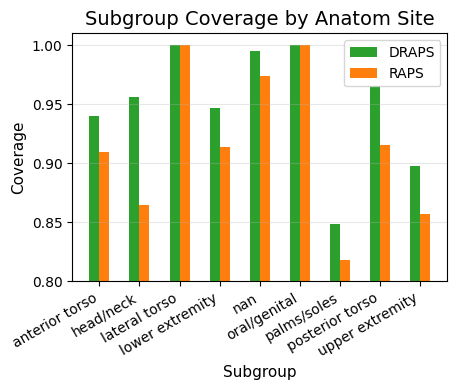

Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.png
Saved: /kaggle/working/out_run30/metrics/figures/subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.pdf


In [178]:
import numpy as np
import pandas as pd

OUT_DIR = "/kaggle/working/out_run30/metrics"
META_CSV = "/kaggle/input/.............../training-dataset/ISIC_2019_Training_Metadata.csv"
SUBGROUP_COL = "anatom_site_general"  

image_ids = np.load(f"{OUT_DIR}/val_image_ids.npy")
y_true    = np.load(f"{OUT_DIR}/val_yhard.npy").astype(int)

def subgroup_coverage(sets_bool, name):
    meta = pd.read_csv(META_CSV).set_index("image")
    meta = meta.loc[image_ids].reset_index()
    sub = meta[SUBGROUP_COL].astype(str).values
    
    rows = []
    for g in np.unique(sub):
        idx = (sub == g)
        if idx.sum() == 0:
            continue
        cov = float(sets_bool[idx, y_true[idx]].mean())
        rows.append({"method": name, "subgroup": g, "n": int(idx.sum()), "coverage": cov})

    df = pd.DataFrame(rows).sort_values("coverage", ascending=False)
    delta = float(df["coverage"].max() - df["coverage"].min())
    return df, delta

df_raps, delta_raps = subgroup_coverage(sets_raps, "RAPS")
print(df_raps)
print(f"\nRAPS coverage gap Δ: {delta_raps:.4f}")

df_draps, delta_draps = subgroup_coverage(sets_draps, "DRAPS")
print("\n" + "="*60 + "\n")
print(df_draps)
print(f"\nDRAPS coverage gap Δ: {delta_draps:.4f}")

plot_df = pd.concat([df_raps, df_draps], ignore_index=True)
pv = plot_df.pivot_table(
    index="subgroup",
    columns="method",
    values="coverage",
    aggfunc="mean"
)
x = np.arange(len(pv.index))
w = 0.25  

fig, ax = plt.subplots(figsize=(4.75, 4))

ax.bar(x - w/2, pv["DRAPS"], width=w, label="DRAPS", color="#2ca02c")
ax.bar(x + w/2, pv["RAPS"],  width=w, label="RAPS",  color="#ff7f0e")

ax.set_xticks(x)
ax.set_xticklabels(pv.index, rotation=30, ha="right")
ax.set_ylabel("Coverage", fontsize=11)
ax.set_xlabel("Subgroup", fontsize=11)
ax.set_title("Subgroup Coverage by Anatom Site", fontsize=14)
ax.set_ylim(0.8, 1.01)
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()

png_path = os.path.join(FIG_DIR, "subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.png")
pdf_path = os.path.join(FIG_DIR, "subgroup_coverage_Anatom_Site_raps_vs_draps_MViTv2.pdf")

plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.savefig(pdf_path, bbox_inches="tight")

plt.show()
plt.close()

print("Saved:", png_path)
print("Saved:", pdf_path)

# Reliability diagram

In [179]:
# Reliability diagram: 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "/kaggle/working/out_run30/metrics" 
EXCEL_OUT = "/kaggle/working/Reliability_MViTv2.xlsx"
N_BINS = 15
PROBS_NPY = os.path.join(OUT_DIR, "val_probs.npy")
YHARD_NPY = os.path.join(OUT_DIR, "val_yhard.npy")

probs  = np.load(PROBS_NPY).astype(float)      
y_true = np.load(YHARD_NPY).astype(int)        

conf = probs.max(axis=1)
pred = probs.argmax(axis=1)
acc  = (pred == y_true).astype(float)

bins = np.linspace(0.0, 1.0, N_BINS + 1)

rows = []
ece = 0.0
for i in range(N_BINS):
    lo, hi = bins[i], bins[i+1]
    m = (conf > lo) & (conf <= hi)
    if m.sum() == 0:
        rows.append({
            "bin": i+1, "lo": lo, "hi": hi, "center": (lo+hi)/2,
            "count": 0, "avg_conf": np.nan, "acc": np.nan, "gap": np.nan
        })
        continue

    p = m.mean()
    a = acc[m].mean()
    c = conf[m].mean()
    gap = abs(a - c)
    ece += p * gap

    rows.append({
        "bin": i+1, "lo": lo, "hi": hi, "center": (lo+hi)/2,
        "count": int(m.sum()), "avg_conf": float(c), "acc": float(a), "gap": float(gap)
    })

df_bins = pd.DataFrame(rows)

with pd.ExcelWriter(EXCEL_OUT, engine="openpyxl") as writer:
    df_bins.to_excel(writer, sheet_name="bins", index=False)
    pd.DataFrame([{
        "OUT_DIR": OUT_DIR,
        "N": int(len(y_true)),
        "K": int(probs.shape[1]),
        "N_BINS": N_BINS,
        "ECE": float(ece),
    }]).to_excel(writer, sheet_name="summary", index=False)

print("Saved Excel MViTv2:", EXCEL_OUT)

use = df_bins.dropna(subset=["avg_conf", "acc"])

plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--")              # perfect calibration
plt.plot(use["avg_conf"].values, use["acc"].values, marker="o", linewidth=1)
plt.xlabel("Confidence", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
# plt.title(f"Reliability Diagram (ECE={ece:.4f})", fontsize=14)
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(FIG_DIR, "reliability_MViTv2.png"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(FIG_DIR, "reliability_MViTv2.pdf"),bbox_inches="tight")
plt.show()
plt.close()

Saved Excel MViTv2: /kaggle/working/Reliability_MViTv2.xlsx


#  Confusion matrix

<Figure size 640x480 with 0 Axes>

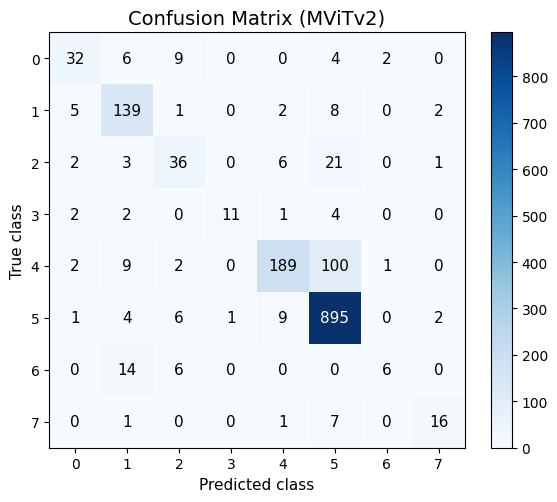

Saved: /kaggle/working/out_run30/metrics/confusion_matrix_MViTv2.csv
Saved: /kaggle/working/out_run30/metrics/confusion_matrix_MViTv2.png
Saved: /kaggle/working/out_run30/metrics/classification_report_MViTv2.csv
Saved: /kaggle/working/out_run30/metrics/classification_report_MViTv2.txt
Saved: /kaggle/working/out_run30/metrics/core_metrics_MViTv2.json


In [180]:
#  Confusion matrix, Precision / Recall / F1 

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)

val_probs = np.load(os.path.join(OUT_DIR, "val_probs.npy"))
val_yhard = np.load(os.path.join(OUT_DIR, "val_yhard.npy"))

y_true = val_yhard.astype(int)
y_pred = val_probs.argmax(axis=1).astype(int)
K = val_probs.shape[1]

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

cm = confusion_matrix(y_true, y_pred, labels=list(range(K)))
cm_df = pd.DataFrame(cm,
                     index=[f"true_{i}" for i in range(K)],
                     columns=[f"pred_{i}" for i in range(K)])
cm_csv = os.path.join(OUT_DIR, "confusion_matrix_MViTv2.csv")
cm_df.to_csv(cm_csv, index=True)

cm_png = os.path.join(OUT_DIR, "confusion_matrix_MViTv2.png")
plt.savefig(os.path.join(OUT_DIR,"confusion_matrix_MViTv2.png"),dpi=300,bbox_inches="tight")
plt.savefig(os.path.join(OUT_DIR,"confusion_matrix_MViTv2.pdf"),bbox_inches="tight")
plt.figure(figsize=(6, 5))
#plt.imshow(cm)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (MViTv2)", fontsize=14)
plt.xlabel("Predicted class", fontsize=11)
plt.ylabel("True class", fontsize=11)
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=11)

plt.tight_layout()
plt.savefig(cm_png, dpi=200)
plt.show()

print("Saved:", cm_csv)
print("Saved:", cm_png)

rep_dict = classification_report(
    y_true, y_pred,
    labels=list(range(K)),
    output_dict=True,
    zero_division=0
)
rep_df = pd.DataFrame(rep_dict).T

rep_csv = os.path.join(OUT_DIR, "classification_report_MViTv2.csv")
rep_df.to_csv(rep_csv, index=True)

rep_txt = os.path.join(OUT_DIR, "classification_report_MViTv2.txt")
with open(rep_txt, "w") as f:
    f.write(classification_report(y_true, y_pred, labels=list(range(K)), zero_division=0))

print("Saved:", rep_csv)
print("Saved:", rep_txt)

# JSON summary 
core = {
    "N": int(len(y_true)),
    "K": int(K),
    "accuracy": float(acc),
    "balanced_accuracy": float(bacc),
    "macro_f1": float(rep_dict["macro avg"]["f1-score"]),
    "weighted_f1": float(rep_dict["weighted avg"]["f1-score"]),
}
core_json = os.path.join(OUT_DIR, "core_metrics_MViTv2.json")
with open(core_json, "w") as f:
    json.dump(core, f, indent=2)

print("Saved:", core_json)


# Per-class ROC–AUC

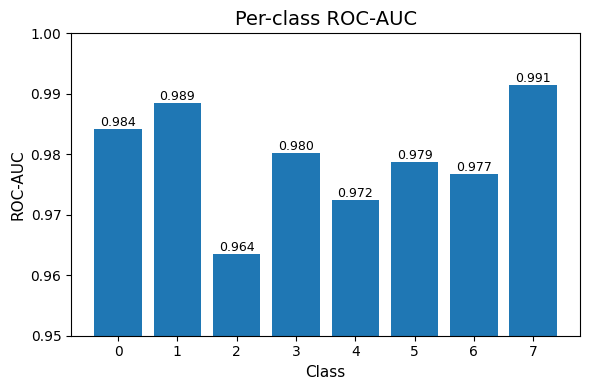

Macro ROC-AUC: 0.9794821043925195
Saved: /kaggle/working/out_run30/metrics/per_class_roc_auc_MViTv2.csv
Saved: /kaggle/working/out_run30/metrics/per_class_roc_auc_MViTv2.png
Saved: /kaggle/working/out_run30/metrics/roc_auc_summary_MViTv2.json


In [181]:
# Per-class ROC–AUC
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

val_probs = np.load(os.path.join(OUT_DIR, "val_probs.npy"))
val_yhard = np.load(os.path.join(OUT_DIR, "val_yhard.npy"))

y_true = val_yhard.astype(int)
probs = val_probs
K = probs.shape[1]
y_onehot = np.eye(K)[y_true]

if (y_true == c).sum() == 0:
    auc = np.nan
else:
    auc = roc_auc_score(y_onehot[:, c], probs[:, c])

auc_per_class = []
for c in range(K):
    if y_onehot[:, c].sum() == 0 or y_onehot[:, c].sum() == len(y_true):
        auc = np.nan
    else:
        auc = roc_auc_score(y_onehot[:, c], probs[:, c])
    auc_per_class.append(auc)

macro_auc = np.nanmean(auc_per_class)

auc_df = pd.DataFrame({
    "class": list(range(K)),
    "roc_auc": auc_per_class
})
auc_csv = os.path.join(OUT_DIR, "per_class_roc_auc_MViTv2.csv")
auc_df.to_csv(auc_csv, index=False)

auc_json = os.path.join(OUT_DIR, "roc_auc_summary_MViTv2.json")
with open(auc_json, "w") as f:
    json.dump({"macro_roc_auc": float(macro_auc)}, f, indent=2)

auc_png = os.path.join(OUT_DIR, "per_class_roc_auc_MViTv2.png")
plt.figure(figsize=(6, 4))
bars = plt.bar(auc_df["class"], auc_df["roc_auc"])
plt.ylim(0.95, 1.0)
plt.xlabel("Class", fontsize=11)
plt.ylabel("ROC-AUC", fontsize=11)
plt.title("Per-class ROC-AUC", fontsize=14)

for bar, val in zip(bars, auc_df["roc_auc"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9
    )
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "per_class_roc_auc_MViTv2.png"),
            dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(OUT_DIR, "per_class_roc_auc_MViTv2.pdf"),
            bbox_inches="tight")
plt.show()
print("Macro ROC-AUC:", macro_auc)
print("Saved:", auc_csv)
print("Saved:", auc_png)
print("Saved:", auc_json)
